In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import json
from collections import Counter
import pickle
import numpy as np

from efficientnet_pytorch import EfficientNet

import torch.optim as optim
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from PIL import Image

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy

import albumentations as A
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2

from sklearn import metrics, model_selection
from sklearn.model_selection import StratifiedKFold

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"

In [2]:
import torchsnooper as sn

# Look at data

# Create model

In [3]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=.1, weight_decay=0.0001):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.n_channels = 3

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.bilinear = True
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )
        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()
                
                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
                
                self.conv = double_conv(in_channels, out_channels)
            def forward(self, x1, x2):
                x1 = self.up(x1)
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]
                
                x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                               diffY//2, diffY-diffY//2])
                x = torch.cat([x2, x1], dim = 1)
                return self.conv(x)
        
        self.inc = double_conv(self.n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.out = nn.Conv2d(64, self.num_classes, kernel_size= 1)

    def forward(self, x):
#         x = x["image"]
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.learning_rate,
                                      weight_decay=self.weight_decay)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=2,
                                                    gamma=0.1)

        return ([optimizer], [scheduler])


#     @sn.snoop()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
#         y = y.long()
        loss = nn.BCEWithLogitsLoss()(preds, y)
        #         loss.requires_grad = True
        im_out = preds.squeeze(0).cpu()
        
        self.logger.experiment.add_image(
                    'epoch_' + str(self.current_epoch) + '_step' + str(self.global_step) + '_generated_images',
                    im_out, 0)
        
        self.log('train_loss', loss,on_step=False)
        return  loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
#         y = y.long()
        preds = self(x)
        loss = nn.BCEWithLogitsLoss()(preds, y)
        #         loss.requires_grad = True
        
#         self.log('val_loss',  on_step=False,loss)
        return loss
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#         tensorboard_logs = {'valid_loss': avg_loss}
        self.log('valid_loss',  avg_loss, on_step=False)
        return avg_loss 
    def on_batch_end(self):
        if self.sched is not None:
            self.sched.step()


In [4]:
class ImageClassDs(Dataset):
    def __init__(self,
                 img_dir, mask_dir,
                 train: bool = True,
                 transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.scale = 1
    
        self.train = train
        self.transforms = transforms
        
        self.ids = os.listdir(self.img_dir)
        self.mask_ids = os.listdir(self.mask_dir)
        
        assert len(self.ids) == len(self.mask_ids)
    
    def preprocess(self, img):
        w, h = img.size
        _h = int(h * self.scale)
        _w = int(w * self.scale)
        assert _w > 0
        assert _h > 0

        _img = img.resize((_w, _h))
        _img = np.array(_img)
        if len(_img.shape) == 2:  ## gray/mask images
            _img = np.expand_dims(_img, axis=-1)

        # hwc to chw
        _img = _img.transpose((2, 0, 1))
        if _img.max() > 1:
            _img = _img / 255.
        return _img

    def __getitem__(self, index):
        im_path = self.ids[index]
        mask_path = self.mask_ids[index]
        im = Image.open(f"{self.img_dir}/{im_path}")
#         im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
#         ma = cv2.imread(f"{self.mask_dir}/{mask_path}", cv2.IMREAD_COLOR)
        ma = Image.open(f"{self.mask_dir}/{mask_path}")
#         ma = cv2.cvtColor(ma, cv2.COLOR_BGR2RGB)
#         print(im.shape, ma.shape)
        
        im = self.preprocess(im)
        ma = self.preprocess(ma)
#         im = self.transforms(image=im) 
#         ma = self.transforms(image=ma)
        
#         return im["image"], ma["image"]
        return torch.from_numpy(im).float(), \
            torch.from_numpy(ma).float()

    def __len__(self):
        return len(self.ids)

# Load data

In [5]:
class ImDataModule(pl.LightningDataModule):
    def __init__(
            self,
            batch_size,
            num_classes,
            data_dir,
            img_size=(256, 256)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = A.Compose([
            A.RandomResizedCrop(img_size, img_size, p=1.0),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2,
                                 sat_shift_limit=0.2,
                                 val_shift_limit=0.2,
                                 p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1),
                                       contrast_limit=(-0.1, 0.1),
                                       p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        max_pixel_value=255.0,
                        p=1.0),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ],
            p=1.)

    def setup(self, stage=None):
        dataset = ImageClassDs(self.data_dir+"train", self.data_dir+"masks", transforms = self.train_transform)
        n_val = int(len(dataset) * 0.1)
        n_train = len(dataset) - n_val
        self.train_dataset, self.valid_dataset = random_split(dataset, [n_train, n_val])

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          pin_memory = True,
                          num_workers=12,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset,
                          batch_size=self.batch_size,
                          pin_memory = True,
                          num_workers=12)

In [6]:
batch_size = 1
num_classes = 3
img_size = 64

In [7]:
dm = ImDataModule(batch_size=batch_size,
                  num_classes=num_classes,
                  img_size=img_size,
                 data_dir = "/media/hdd/Datasets/DenseHaze/")
class_ids = dm.setup()

# Logs

In [8]:
model = LitModel(num_classes)

In [9]:
logger = TensorBoardLogger(save_dir="logs")

In [10]:
trainer = pl.Trainer(auto_select_gpus=True,
                     gpus=1,
                     precision=16,
                     profiler=False,
                     max_epochs=100,
                     callbacks=[pl.callbacks.ProgressBar()],
                     enable_pl_optimizer=True,
                     logger=logger,
                     accumulate_grad_batches=16,
                     accelerator='ddp',
                     plugins='ddp_sharded')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
/home/eragon/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: plugin <class 'pytorch_lightning.plugins.sharded_plugin.DDPShardedPlugin'> has added additional required plugins as default: [<class 'pytorch_lightning.plugins.sharded_native_amp_plugin.ShardedNativeAMPPlugin'>]Extend this plugin and override `required_plugins`if this conflicts with your additional plugins.
  warnings.warn(*args, **kwargs)


In [11]:
trainer.fit(model, dm)

initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1

  | Name  | Type       | Params
-------------------------------------
0 | inc   | Sequential | 39.0 K
1 | down1 | Sequential | 221 K 
2 | down2 | Sequential | 886 K 
3 | down3 | Sequential | 3.5 M 
4 | down4 | Sequential | 4.7 M 
5 | up1   | up         | 3.0 M 
6 | up2   | up         | 738 K 
7 | up3   | up         | 184 K 
8 | up4   | up         | 110 K 
9 | out   | Conv2d     | 195   
-------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/eragon/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/eragon/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [16]:
trainer.save_checkpoint('model1.ckpt')

# Inference

In [20]:
best_checkpoints = trainer.checkpoint_callback.best_model_path

pre_model = LitModel.load_from_checkpoint(checkpoint_path= best_checkpoints).to("cuda")

pre_model.eval()
pre_model.freeze()

In [36]:
test_img = Image.open("/home/eragon/Downloads/t1.jpg")

In [37]:
y_hat = pre_model(transforms.ToTensor()(test_img).unsqueeze(0).to("cuda"))

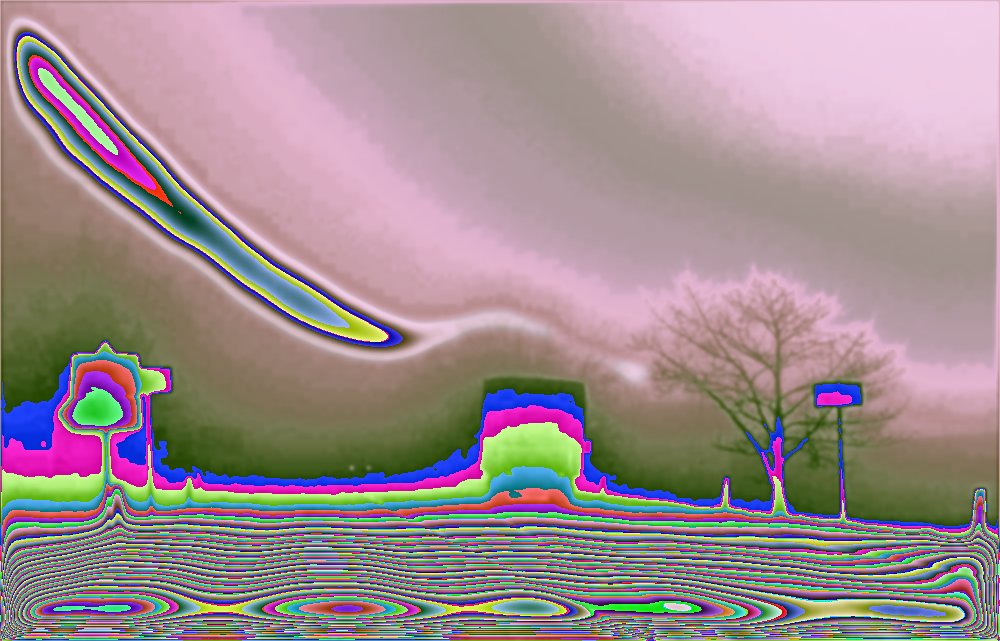

In [38]:
transforms.ToPILImage()(y_hat.squeeze(0)).convert("RGB")